In [60]:
# Auto-reload modules for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SignalBuilderV02 demonstration notebook



This notebook illustrates how to use the `SignalBuilderV02` package to:



- Generate non-uniform frequency profiles (low / high / no-change segments).

- Build spline-based amplitude envelopes.

- Synthesize example temporal signals from these components.

- Visualize the resulting signals and profiles.


In [61]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

from SignalBuilderV02.frequency_profiles import generate_non_uniform_high_low_frequency_points
from SignalBuilderV02.splines import tension_spline_interpolator
from SignalBuilderV02.noise_profiles import NoiseProfileConfig, apply_noise_profile

# Force fresh import after module changes
import importlib
import SignalBuilderV02.noise_profiles
importlib.reload(SignalBuilderV02.noise_profiles)
from SignalBuilderV02.noise_profiles import NoiseProfileConfig, apply_noise_profile


def generate_random_amplitude_envelope(t: np.ndarray, rng=None):
    """Generate a random amplitude envelope over `t` using a tension spline.

    This mirrors the original SignalBuilder amplitude constructor:
    - random amplitude and frequency (with random sign, integer magnitude 1..9),
    - random phase in [0, pi],
    - 1 to 4 interior control points,
    - amplitude floor around 0.5,
    - tau aleatorio en {1,3,5,8,10,12,15,20} con 50% probabilidad,
    - 50% step function (zero-order spline).
    """
    import numpy as _np
    from SignalBuilderV02.splines import zero_order_spline_interpolator

    if rng is None:
        rng = _np.random.default_rng()

    t = _np.asarray(t, dtype=float)
    x0 = float(t[0])
    x1 = float(t[-1])

    # Amplitud más alta (3-15) para mayor contraste visual
    amplitude = (2 * rng.random() - 1.0) * rng.integers(3, 16)
    frequency = (2 * rng.random() - 1.0) * rng.integers(1, 10)
    phase = rng.random() * _np.pi

    num_points = int(rng.integers(1, 5))
    partition = _np.linspace(x0, x1, num_points + 2)

    amp_knots = []
    amp_values = []
    for x in partition:
        y = amplitude * _np.sin(frequency * (x - phase))
        y = abs(y)
        if y < 0.5:
            y = abs(amplitude * rng.uniform(0.5, 1.0))
        amp_knots.append(float(x))
        amp_values.append(float(y))

    amp_knots = _np.asarray(amp_knots, dtype=float)
    amp_values = _np.asarray(amp_values, dtype=float)

    # 70% step function (variaciones bruscas) vs 30% tension spline
    use_tension = rng.choice([True, False], p=[0.3, 0.7])
    if use_tension:
        tau = float(rng.choice([1, 3, 5, 8, 10, 12, 15, 20]))
        amp_spline = tension_spline_interpolator(amp_knots, amp_values, tau=tau)
        amp_envelope = amp_spline(t)
        spline_type = 'tension'
    else:
        points = list(zip(amp_knots, amp_values))
        amp_spline = zero_order_spline_interpolator(points)
        amp_envelope = amp_spline(t)
        tau = None
        spline_type = 'zero_order'

    return amp_envelope, amp_knots, amp_values, tau, spline_type

## 1. Generate a non-uniform frequency profile

We start by creating a non-uniform frequency profile over a given time interval.

The profile consists of low-frequency baseline segments, occasional high-frequency bursts,

and explicit segment labels (`low`, `high`, `no_change`).

In [62]:
# Define time interval (seconds)

t_start = 0.0

t_end = 10.0



# Generate non-uniform frequency profile

base_points, high_freq_points, variation_type = (

    generate_non_uniform_high_low_frequency_points(t_start, t_end)

)



base_times = np.array([p[0] for p in base_points])

base_freqs = np.array([p[1] for p in base_points])



high_times = np.array([p[0] for p in high_freq_points])

high_freqs = np.array([p[1] for p in high_freq_points])



variation_type

['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']

### Plot the base and high-frequency components

We visualize the base low-frequency profile and the high-frequency bursts

produced by `generate_non_uniform_high_low_frequency_points`.

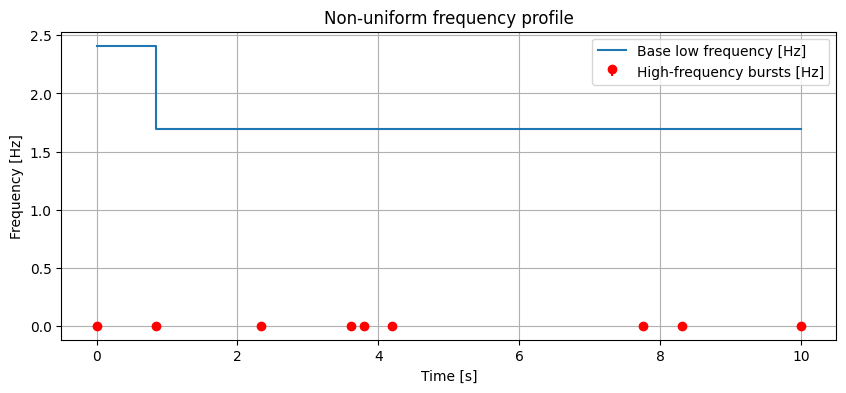

In [63]:
plt.figure(figsize=(10, 4))

plt.step(base_times, base_freqs, where='post', label='Base low frequency [Hz]')

plt.stem(

    high_times,

    high_freqs,

    linefmt='r-',

    markerfmt='ro',

    basefmt=' ',

    label='High-frequency bursts [Hz]',

)

plt.xlabel('Time [s]')

plt.ylabel('Frequency [Hz]')

plt.title('Non-uniform frequency profile')

plt.legend()

plt.grid(True)

plt.show()

## 2. Build a spline-based amplitude envelope

Next, we construct an amplitude envelope using the tension spline interpolator.

This envelope can later be used to modulate the amplitude of a synthetic signal.

In [ ]:
def generate_demo_signal(t_start: float,
                         t_end: float,
                         fs_high: float,
                         noise_config: NoiseProfileConfig,
                         rng: np.random.Generator):
    """Generate one demo signal with random envelopes and noise.

    Frequency profile uses tau aleatorio en [1, 2] (paso 0.05).
    Amplitude envelope uses tau aleatorio en {1,3,5,8,10,12,15,20} con 50% probabilidad
    o step function (50%).
    """
    # High-resolution time axis
    t_high = np.arange(t_start, t_end, 1.0 / fs_high)

    # Frequency profile (API without rng)
    base_points, high_freq_points, variation_type = generate_non_uniform_high_low_frequency_points(
        t_start, t_end
)
    base_times = np.array([p[0] for p in base_points])
    base_freqs = np.array([p[1] for p in base_points])

    # Spline-based instantaneous frequency with random tau in [1, 2]
    tau_freq = float(rng.choice(np.linspace(1, 2, 21)))
    base_interp = tension_spline_interpolator(base_times, base_freqs, tau=tau_freq)
    inst_freq = base_interp(t_high)

    # Random amplitude envelope using the same t_high grid
    amp_envelope, amp_knots, amp_values, tau_amp, spline_type = generate_random_amplitude_envelope(
        t_high, rng=rng
)

    # Random vertical offset with normal distribution (concentrated around 0)
    # ~68% within [-3, 3], ~95% within [-6, 6], ~99.7% within [-9, 9]
    offset = rng.normal(loc=0.0, scale=3.0)

    # Phase and clean signal
    phase = 2 * np.pi * np.cumsum(inst_freq) / fs_high
    clean_signal = amp_envelope * np.sin(phase) + offset

    # Apply noise profile with the correct signature
    noisy_signal, noise_metadata = apply_noise_profile(
        rng=rng,
        clean_signal=clean_signal,
        t_high=t_high,
        t_start=t_start,
        t_end=t_end,
        base_points=base_points,
        variation_type=variation_type,
        config=noise_config,
    )

    signal_metadata = {
        "t_start": float(t_start),
        "t_end": float(t_end),
        "fs_high": float(fs_high),
        "tau_frequency": tau_freq,
        "tau_amplitude": tau_amp if tau_amp is not None else "N/A",
        "amplitude_spline_type": spline_type,
        "vertical_offset": float(offset),
        "base_points": base_points,
        "high_freq_points": high_freq_points,
        "variation_type": variation_type,
        "amp_knots": [float(x) for x in amp_knots],
        "amp_values": [float(y) for y in amp_values],
        "noise_profile": noise_metadata,
    }

    return t_high, clean_signal, noisy_signal, signal_metadata

## 3. Synthesize a simple example signal

As a first step, we synthesize a signal whose instantaneous frequency

follows the base low-frequency profile, and whose amplitude is given by

the tension-spline envelope. This is a simplified example of the full

generation pipeline described in the architecture document.

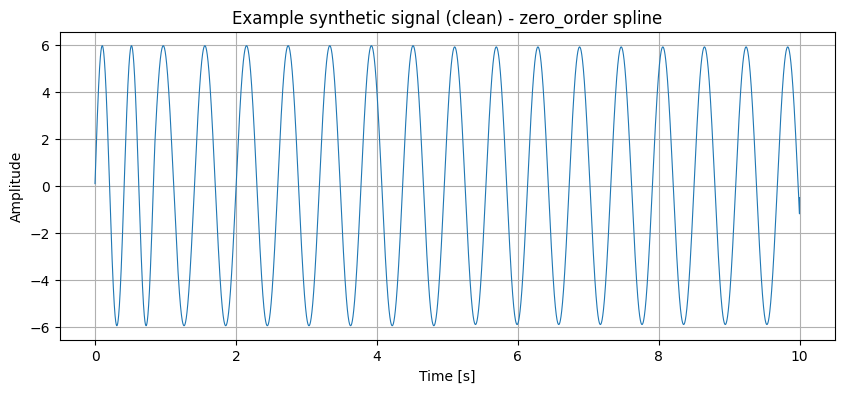

In [65]:
# Define sampling rate and time axis
fs_high = 1000.0  # Hz
t_high = np.arange(t_start, t_end, 1.0 / fs_high)

# Build a stepwise frequency envelope from the base profile
from SignalBuilderV02.splines import zero_order_spline_interpolator
freq_step = zero_order_spline_interpolator(base_points)
inst_freq = freq_step(t_high)

# Integrate instantaneous frequency to get phase
phase = 2 * np.pi * np.cumsum(inst_freq) / fs_high

# Recompute amplitude envelope on the same t_high grid
rng_demo = np.random.default_rng(42)
amp_envelope, amp_knots, amp_values, tau_amp, spline_type = generate_random_amplitude_envelope(
    t_high, rng=rng_demo
)

# Clean (noise-free) signal
clean_signal = amp_envelope * np.sin(phase)

plt.figure(figsize=(10, 4))
plt.plot(t_high, clean_signal, linewidth=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Example synthetic signal (clean) - {spline_type} spline')
plt.grid(True)
plt.show()

## 4. Add simple Gaussian noise (prototype noise model)

To illustrate how noise can be added, we include a basic Gaussian noise

model with a configurable standard deviation. More sophisticated noise

models (e.g., band-limited noise) can be added following the same pattern.

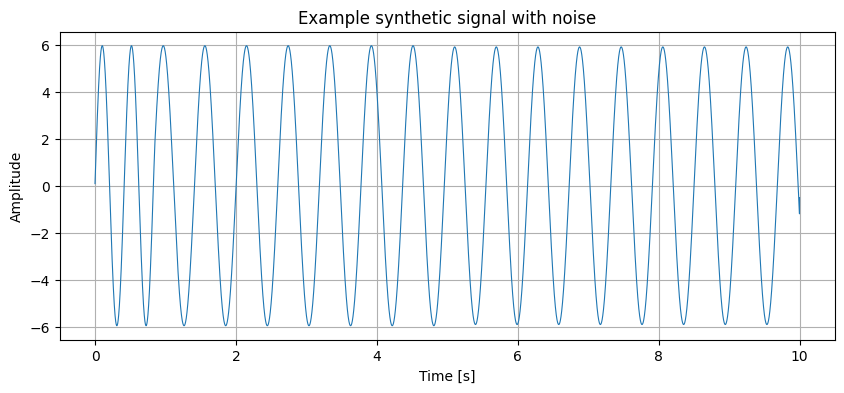

In [66]:
# Set random seed for reproducibility

rng = np.random.default_rng(seed=42)



# Noise configuration: 10% chance of noise, 50% Gaussian / 50% structured

noise_config = NoiseProfileConfig(
    p_has_noise=0.1,
    p_gaussian=0.5,
    gaussian_std_relative=0.15,
)



# Apply noise profile to the clean signal

noisy_signal, noise_metadata = apply_noise_profile(
    rng=rng,
    clean_signal=clean_signal,
    t_high=t_high,
    t_start=t_start,
    t_end=t_end,
    base_points=base_points,
    variation_type=variation_type,
    config=noise_config,
)



plt.figure(figsize=(10, 4))

plt.plot(t_high, noisy_signal, linewidth=0.8)

plt.xlabel('Time [s]')

plt.ylabel('Amplitude')

plt.title('Example synthetic signal with noise')

plt.grid(True)

plt.show()

## 5. Sketch of metadata for one signal

Finally, we assemble a prototype metadata dictionary for the generated signal.

In the full implementation this dictionary (or a similar structure) would be

saved alongside the signal in JSON or CSV form.

In [67]:
# Prototype metadata for this signal

signal_metadata = {

    'signal_id': 'demo_signal_0001',

    'seed': 42,

    'duration': float(t_end - t_start),

    'fs_high': float(fs_high),

    'low_freq_points': base_points,

    'high_freq_points': high_freq_points,

    'variation_type': variation_type,

    'amplitude_knots': amp_knots,

    'amplitude_values': amp_values,

    'noise_profile': noise_metadata,

    'generation_version': 'SignalBuilderV02-demo',

}

signal_metadata


{'signal_id': 'demo_signal_0001',
 'seed': 42,
 'duration': 10.0,
 'fs_high': 1000.0,
 'low_freq_points': [(0.0, 2.4109494763225587),
  (0.8470140306647578, 1.692487171592333),
  (2.3413474371977907, 1.692487171592333),
  (3.6097830161864533, 1.692487171592333),
  (3.7969219310890487, 1.692487171592333),
  (4.194864166037263, 1.692487171592333),
  (7.754595823029576, 1.692487171592333),
  (8.309373215587478, 1.692487171592333),
  (10.0, 1.692487171592333)],
 'high_freq_points': [(0.0, 0.0),
  (0.8470140306647578, 0.0),
  (2.3413474371977907, 0.0),
  (3.6097830161864533, 0.0),
  (3.7969219310890487, 0.0),
  (4.194864166037263, 0.0),
  (7.754595823029576, 0.0),
  (8.309373215587478, 0.0),
  (10.0, 0.0)],
 'variation_type': ['low',
  'low',
  'low',
  'low',
  'low',
  'low',
  'low',
  'low',
  'low'],
 'amplitude_knots': array([0.    , 4.9995, 9.999 ]),
 'amplitude_values': array([5.95357062, 5.90274285, 2.39553633]),
 'noise_profile': {'has_noise': False,
  'noise_type': 'none',
  'p_h

## 6. Helper function to generate one signal

This helper wraps the previous steps into a single function that returns

the time axis, clean and noisy signals, and the metadata dictionary.

In [68]:
# Batch generation: 100 signals
num_signals = 100
fs_high = 1024.0
t_start = 0.0
t_end = 4 * np.pi

# Noise configuration - 50% con ruido para dataset de entrenamiento
noise_config = NoiseProfileConfig(
    p_has_noise=0.5,
    p_gaussian=0.5,
    gaussian_std_relative=0.15
)

for i in range(num_signals):
    # Use unique seed per signal
    seed = 1000 + i
    rng = default_rng(seed)
    
    # Generate signal
    t_high, clean_signal, noisy_signal, signal_metadata = generate_demo_signal(
        t_start=t_start,
        t_end=t_end,
        fs_high=fs_high,
        noise_config=noise_config,
        rng=rng
    )
    
    # Add seed to metadata
    signal_metadata['seed'] = seed
    signal_metadata['signal_id'] = f'signal_{i:03d}'
    signal_metadata['frequency_profile_type'] = 'non_uniform_high_low'
    signal_metadata['noise_type'] = signal_metadata['noise_profile']['noise_type']
    
    # Save signal data
    signal_path = f"SignalBuilderV02/data/signals/signal_{i:03d}.npz"
    np.savez(
        signal_path,
        noisy_signal=noisy_signal,
        clean_signal=clean_signal,
        t=t_high,
        frequency_profile=signal_metadata['base_points'],
        amplitude_envelope=signal_metadata['amp_values']
    )
    
    # Save metadata
    metadata_path = f"SignalBuilderV02/data/metadata/signal_{i:03d}.json"
    with open(metadata_path, 'w') as f:
        json.dump(signal_metadata, f, indent=2)
    
    # Create and save figure
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(t_high, noisy_signal, linewidth=0.8, color='steelblue')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Signal {i:03d} | Noise: {signal_metadata["noise_type"]} | Amp Spline: {signal_metadata["amplitude_spline_type"]}')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    
    fig_path = f"SignalBuilderV02/figures/signal_{i:03d}.png"
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
    if (i + 1) % 10 == 0:
        print(f"Generated {i + 1}/{num_signals} signals")

print(f"\nCompleted! Generated {num_signals} signals")

# Create metadata index
metadata_index = []
for i in range(num_signals):
    metadata_path = f"SignalBuilderV02/data/metadata/signal_{i:03d}.json"
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    metadata_index.append({
        'signal_id': i,
        'seed': metadata['seed'],
        'noise_type': metadata['noise_type'],
        'frequency_profile_type': metadata['frequency_profile_type'],
        'amplitude_spline_type': metadata['amplitude_spline_type'],
        'tau_frequency': metadata['tau_frequency'],
        'tau_amplitude': metadata['tau_amplitude']
    })

index_path = "SignalBuilderV02/data/metadata/metadata_index.json"
with open(index_path, 'w') as f:
    json.dump(metadata_index, f, indent=2)

print(f"Metadata index saved to {index_path}")

Generated 10/100 signals
Generated 20/100 signals
Generated 20/100 signals
Generated 30/100 signals
Generated 30/100 signals
Generated 40/100 signals
Generated 40/100 signals
Generated 50/100 signals
Generated 50/100 signals
Generated 60/100 signals
Generated 60/100 signals
Generated 70/100 signals
Generated 70/100 signals
Generated 80/100 signals
Generated 80/100 signals
Generated 90/100 signals
Generated 90/100 signals
Generated 100/100 signals

Completed! Generated 100 signals
Metadata index saved to SignalBuilderV02/data/metadata/metadata_index.json
Generated 100/100 signals

Completed! Generated 100 signals
Metadata index saved to SignalBuilderV02/data/metadata/metadata_index.json
